In [1]:
import pandas as pd
import numpy as np
from models_ncf.neumf import NeuMFEngine
from models_ncf.data import SampleGenerator

In [2]:
neumf_config = {'alias': 'neumf_first_try',
                'num_epoch': 10,
                'batch_size': 1024,
                'optimizer': 'adam',
                'adam_lr': 1e-3,
                'num_users': 6040,
                'num_items': 3706,
                'latent_dim_mf': 8,
                'latent_dim_mlp': 8,
                'num_negative': 4,
                'layers': [16, 64, 32, 16, 8],  # layers[0] is the concat of latent user vector & latent item vector
                'l2_regularization': 0.0000001,
                'weight_init_gaussian': True,
                'use_cuda': True,
                'use_bachify_eval': True,
                'device_id': 0,
                'pretrain': False,
                'pretrain_mf': 'checkpoints/{}'.format('gmf_factor8neg4_Epoch100_precision0.6391_recall0.2852.model'),
                'pretrain_mlp': 'checkpoints/{}'.format('mlp_factor8neg4_Epoch100_precision0.5606_recall0.2463.model'),
                'model_dir': 'checkpoints/{}_Epoch{}_precision{:.4f}_recall{:.4f}.model'
                }

In [3]:
import torch

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    print("CUDA is available. Using GPU.")
else:
    print("CUDA is not available. Using CPU.")


CUDA is available. Using GPU.


In [11]:
# Load Data
ml1m_dir = 'ml-1m/ratings.dat'
ml1m_rating = pd.read_csv(ml1m_dir, sep='::', header=None, names=['uid', 'mid', 'rating', 'timestamp'], engine='python')
ml1m_rating

,uid,mid,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [8]:
# Reindex
user_id = ml1m_rating[['uid']].drop_duplicates().reindex()
user_id['userId'] = np.arange(len(user_id))
ml1m_rating = pd.merge(ml1m_rating, user_id, on=['uid'], how='left')
item_id = ml1m_rating[['mid']].drop_duplicates()
item_id['itemId'] = np.arange(len(item_id))
ml1m_rating = pd.merge(ml1m_rating, item_id, on=['mid'], how='left')
ml1m_rating = ml1m_rating[['userId', 'itemId', 'rating', 'timestamp']]
print('Range of userId is [{}, {}]'.format(ml1m_rating.userId.min(), ml1m_rating.userId.max()))
print('Range of itemId is [{}, {}]'.format(ml1m_rating.itemId.min(), ml1m_rating.itemId.max()))
# DataLoader for training 
sample_generator = SampleGenerator(ratings=ml1m_rating)
evaluate_data = sample_generator.evaluate_data

config = neumf_config
engine = NeuMFEngine(config)
for epoch in range(config['num_epoch']):
    print('Epoch {} starts !'.format(epoch))
    print('-' * 80)
    train_loader = sample_generator.instance_a_train_loader(config['num_negative'], config['batch_size'])
    engine.train_an_epoch(train_loader, epoch_id=epoch)
    precision, recall = engine.evaluate(evaluate_data, epoch_id=epoch)
    engine.save(config['alias'], epoch, precision, recall)

Range of userId is [0, 6039]
Range of itemId is [0, 3705]
Index(['userId', 'itemId', 'rating', 'real_score', 'negative_samples'], dtype='object')
Embedding(6040, 8)
Embedding(3706, 8)
Embedding(6040, 8)
Embedding(3706, 8)
Linear(in_features=16, out_features=64, bias=True)
Linear(in_features=64, out_features=32, bias=True)
Linear(in_features=32, out_features=16, bias=True)
Linear(in_features=16, out_features=8, bias=True)
Linear(in_features=16, out_features=1, bias=True)
NeuMF(
  (embedding_user_mlp): Embedding(6040, 8)
  (embedding_item_mlp): Embedding(3706, 8)
  (embedding_user_mf): Embedding(6040, 8)
  (embedding_item_mf): Embedding(3706, 8)
  (fc_layers): ModuleList(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=8, bias=True)
  )
  (affine_output): Linear(in_features=16, out_features=1, bias=True)
  (logist

100%|██████████| 9935/9935 [00:04<00:00, 2019.09it/s]


Length of test_users: 102759
Length of test_items: 102759
Length of test_preds: 102759
[Evaluating Epoch 0] Precision = 0.2623, Recall = 0.7758
Epoch 1 starts !
--------------------------------------------------------------------------------
[Training Epoch 1] Batch 0, Loss 0.3102486729621887
[Training Epoch 1] Batch 1, Loss 0.310570627450943
[Training Epoch 1] Batch 2, Loss 0.31516993045806885
[Training Epoch 1] Batch 3, Loss 0.3371031582355499
[Training Epoch 1] Batch 4, Loss 0.31891119480133057
[Training Epoch 1] Batch 5, Loss 0.2950422763824463
[Training Epoch 1] Batch 6, Loss 0.29444846510887146
[Training Epoch 1] Batch 7, Loss 0.30788883566856384
[Training Epoch 1] Batch 8, Loss 0.3101208806037903
[Training Epoch 1] Batch 9, Loss 0.3221988081932068
[Training Epoch 1] Batch 10, Loss 0.29978638887405396
[Training Epoch 1] Batch 11, Loss 0.316616952419281
[Training Epoch 1] Batch 12, Loss 0.30091363191604614
[Training Epoch 1] Batch 13, Loss 0.33852726221084595
[Training Epoch 1] Ba

100%|██████████| 9935/9935 [00:05<00:00, 1984.57it/s]


Length of test_users: 102759
Length of test_items: 102759
Length of test_preds: 102759
[Evaluating Epoch 1] Precision = 0.2616, Recall = 0.7744
Epoch 2 starts !
--------------------------------------------------------------------------------
[Training Epoch 2] Batch 0, Loss 0.26416850090026855
[Training Epoch 2] Batch 1, Loss 0.2735558748245239
[Training Epoch 2] Batch 2, Loss 0.31524890661239624
[Training Epoch 2] Batch 3, Loss 0.25924068689346313
[Training Epoch 2] Batch 4, Loss 0.2707514762878418
[Training Epoch 2] Batch 5, Loss 0.2809693217277527
[Training Epoch 2] Batch 6, Loss 0.2827235758304596
[Training Epoch 2] Batch 7, Loss 0.2767148017883301
[Training Epoch 2] Batch 8, Loss 0.279736191034317
[Training Epoch 2] Batch 9, Loss 0.27633699774742126
[Training Epoch 2] Batch 10, Loss 0.24467654526233673
[Training Epoch 2] Batch 11, Loss 0.26477566361427307
[Training Epoch 2] Batch 12, Loss 0.2683340311050415
[Training Epoch 2] Batch 13, Loss 0.2709121108055115
[Training Epoch 2] Ba

100%|██████████| 9935/9935 [00:05<00:00, 1982.82it/s]


Length of test_users: 102759
Length of test_items: 102759
Length of test_preds: 102759
[Evaluating Epoch 2] Precision = 0.2618, Recall = 0.7739
Epoch 3 starts !
--------------------------------------------------------------------------------
[Training Epoch 3] Batch 0, Loss 0.25511133670806885
[Training Epoch 3] Batch 1, Loss 0.2802758812904358
[Training Epoch 3] Batch 2, Loss 0.2823371887207031
[Training Epoch 3] Batch 3, Loss 0.2376820147037506
[Training Epoch 3] Batch 4, Loss 0.2570372223854065
[Training Epoch 3] Batch 5, Loss 0.2648353576660156
[Training Epoch 3] Batch 6, Loss 0.25178927183151245
[Training Epoch 3] Batch 7, Loss 0.28661486506462097
[Training Epoch 3] Batch 8, Loss 0.26621532440185547
[Training Epoch 3] Batch 9, Loss 0.27830183506011963
[Training Epoch 3] Batch 10, Loss 0.2709539532661438
[Training Epoch 3] Batch 11, Loss 0.2533772587776184
[Training Epoch 3] Batch 12, Loss 0.24482455849647522
[Training Epoch 3] Batch 13, Loss 0.2822796404361725
[Training Epoch 3] B

100%|██████████| 9935/9935 [00:04<00:00, 2223.54it/s]


Length of test_users: 102759
Length of test_items: 102759
Length of test_preds: 102759
[Evaluating Epoch 3] Precision = 0.2619, Recall = 0.7748
Epoch 4 starts !
--------------------------------------------------------------------------------
[Training Epoch 4] Batch 0, Loss 0.2556823492050171
[Training Epoch 4] Batch 1, Loss 0.28345590829849243
[Training Epoch 4] Batch 2, Loss 0.2937825620174408
[Training Epoch 4] Batch 3, Loss 0.2649540305137634
[Training Epoch 4] Batch 4, Loss 0.26128697395324707
[Training Epoch 4] Batch 5, Loss 0.28206369280815125
[Training Epoch 4] Batch 6, Loss 0.2702205181121826
[Training Epoch 4] Batch 7, Loss 0.26273679733276367
[Training Epoch 4] Batch 8, Loss 0.29760515689849854
[Training Epoch 4] Batch 9, Loss 0.26975882053375244
[Training Epoch 4] Batch 10, Loss 0.24201813340187073
[Training Epoch 4] Batch 11, Loss 0.27197104692459106
[Training Epoch 4] Batch 12, Loss 0.28219422698020935
[Training Epoch 4] Batch 13, Loss 0.2484714686870575
[Training Epoch 4

100%|██████████| 9935/9935 [00:04<00:00, 2236.58it/s]


Length of test_users: 102759
Length of test_items: 102759
Length of test_preds: 102759
[Evaluating Epoch 4] Precision = 0.2615, Recall = 0.7742
Epoch 5 starts !
--------------------------------------------------------------------------------
[Training Epoch 5] Batch 0, Loss 0.28261321783065796
[Training Epoch 5] Batch 1, Loss 0.2614433169364929
[Training Epoch 5] Batch 2, Loss 0.2504774034023285
[Training Epoch 5] Batch 3, Loss 0.2848097085952759
[Training Epoch 5] Batch 4, Loss 0.27237385511398315
[Training Epoch 5] Batch 5, Loss 0.25333815813064575
[Training Epoch 5] Batch 6, Loss 0.2596832513809204
[Training Epoch 5] Batch 7, Loss 0.2382521778345108
[Training Epoch 5] Batch 8, Loss 0.2619789242744446
[Training Epoch 5] Batch 9, Loss 0.26289230585098267
[Training Epoch 5] Batch 10, Loss 0.24932755529880524
[Training Epoch 5] Batch 11, Loss 0.25418782234191895
[Training Epoch 5] Batch 12, Loss 0.22430717945098877
[Training Epoch 5] Batch 13, Loss 0.2638402581214905
[Training Epoch 5] 

100%|██████████| 9935/9935 [00:04<00:00, 2252.51it/s]


Length of test_users: 102759
Length of test_items: 102759
Length of test_preds: 102759
[Evaluating Epoch 5] Precision = 0.2617, Recall = 0.7735
Epoch 6 starts !
--------------------------------------------------------------------------------
[Training Epoch 6] Batch 0, Loss 0.25592997670173645
[Training Epoch 6] Batch 1, Loss 0.282188355922699
[Training Epoch 6] Batch 2, Loss 0.23869386315345764
[Training Epoch 6] Batch 3, Loss 0.2686041593551636
[Training Epoch 6] Batch 4, Loss 0.23837636411190033
[Training Epoch 6] Batch 5, Loss 0.27058589458465576
[Training Epoch 6] Batch 6, Loss 0.2397046536207199
[Training Epoch 6] Batch 7, Loss 0.27085453271865845
[Training Epoch 6] Batch 8, Loss 0.2577418386936188
[Training Epoch 6] Batch 9, Loss 0.25823163986206055
[Training Epoch 6] Batch 10, Loss 0.24811668694019318
[Training Epoch 6] Batch 11, Loss 0.2471630573272705
[Training Epoch 6] Batch 12, Loss 0.2279222160577774
[Training Epoch 6] Batch 13, Loss 0.23365555703639984
[Training Epoch 6] 

100%|██████████| 9935/9935 [00:04<00:00, 2249.31it/s]


Length of test_users: 102759
Length of test_items: 102759
Length of test_preds: 102759
[Evaluating Epoch 6] Precision = 0.2616, Recall = 0.7742
Epoch 7 starts !
--------------------------------------------------------------------------------
[Training Epoch 7] Batch 0, Loss 0.26679566502571106
[Training Epoch 7] Batch 1, Loss 0.26301443576812744
[Training Epoch 7] Batch 2, Loss 0.2682517468929291
[Training Epoch 7] Batch 3, Loss 0.25288259983062744
[Training Epoch 7] Batch 4, Loss 0.2551305890083313
[Training Epoch 7] Batch 5, Loss 0.25813063979148865
[Training Epoch 7] Batch 6, Loss 0.24982918798923492
[Training Epoch 7] Batch 7, Loss 0.21772320568561554
[Training Epoch 7] Batch 8, Loss 0.26245301961898804
[Training Epoch 7] Batch 9, Loss 0.2542659044265747
[Training Epoch 7] Batch 10, Loss 0.24336403608322144
[Training Epoch 7] Batch 11, Loss 0.2431619018316269
[Training Epoch 7] Batch 12, Loss 0.2563738226890564
[Training Epoch 7] Batch 13, Loss 0.2836723327636719
[Training Epoch 7]

100%|██████████| 9935/9935 [00:04<00:00, 2253.08it/s]


Length of test_users: 102759
Length of test_items: 102759
Length of test_preds: 102759
[Evaluating Epoch 7] Precision = 0.2618, Recall = 0.7740
Epoch 8 starts !
--------------------------------------------------------------------------------
[Training Epoch 8] Batch 0, Loss 0.24442420899868011
[Training Epoch 8] Batch 1, Loss 0.2280518114566803
[Training Epoch 8] Batch 2, Loss 0.270414799451828
[Training Epoch 8] Batch 3, Loss 0.25201594829559326
[Training Epoch 8] Batch 4, Loss 0.23222514986991882
[Training Epoch 8] Batch 5, Loss 0.22619274258613586
[Training Epoch 8] Batch 6, Loss 0.2465355098247528
[Training Epoch 8] Batch 7, Loss 0.2548137903213501
[Training Epoch 8] Batch 8, Loss 0.26101115345954895
[Training Epoch 8] Batch 9, Loss 0.26516491174697876
[Training Epoch 8] Batch 10, Loss 0.2525690197944641
[Training Epoch 8] Batch 11, Loss 0.2738725244998932
[Training Epoch 8] Batch 12, Loss 0.24929918348789215
[Training Epoch 8] Batch 13, Loss 0.2749224901199341
[Training Epoch 8] B

100%|██████████| 9935/9935 [00:04<00:00, 2221.78it/s]


Length of test_users: 102759
Length of test_items: 102759
Length of test_preds: 102759
[Evaluating Epoch 8] Precision = 0.2622, Recall = 0.7758
Epoch 9 starts !
--------------------------------------------------------------------------------
[Training Epoch 9] Batch 0, Loss 0.23814447224140167
[Training Epoch 9] Batch 1, Loss 0.23979857563972473
[Training Epoch 9] Batch 2, Loss 0.24079301953315735
[Training Epoch 9] Batch 3, Loss 0.21342912316322327
[Training Epoch 9] Batch 4, Loss 0.2770538628101349
[Training Epoch 9] Batch 5, Loss 0.2356378734111786
[Training Epoch 9] Batch 6, Loss 0.2509317994117737
[Training Epoch 9] Batch 7, Loss 0.26008325815200806
[Training Epoch 9] Batch 8, Loss 0.22588370740413666
[Training Epoch 9] Batch 9, Loss 0.25613105297088623
[Training Epoch 9] Batch 10, Loss 0.25647470355033875
[Training Epoch 9] Batch 11, Loss 0.22597840428352356
[Training Epoch 9] Batch 12, Loss 0.24643301963806152
[Training Epoch 9] Batch 13, Loss 0.24360990524291992
[Training Epoch

100%|██████████| 9935/9935 [00:04<00:00, 2257.26it/s]


Length of test_users: 102759
Length of test_items: 102759
Length of test_preds: 102759
[Evaluating Epoch 9] Precision = 0.2612, Recall = 0.7725


In [13]:
goodbooks_dir = 'goodbooks-10k/ratings.csv'
goodbooks_rating = pd.read_csv(goodbooks_dir)   

user_ids = goodbooks_rating['uid'].sample(n=1000, random_state=42).unique()
goodbooks_rating = goodbooks_rating[goodbooks_rating['uid'].isin(user_ids)]

# Filter out books with less than 100 ratings
book_counts = goodbooks_rating['mid'].value_counts()
book_ids = (book_counts[book_counts >= 30].index)
goodbooks_rating = goodbooks_rating[goodbooks_rating['mid'].isin(book_ids)]

In [14]:
goodbooks_rating

,uid,mid,rating,timestamp
622,55,212,5,0
624,55,1544,5,0
643,55,264,5,0
644,55,397,2,0
645,55,653,5,0
...,...,...,...,...
1047863,7747,366,5,0
1047867,7747,144,5,0
1047954,7747,179,3,0
1048028,7747,1641,5,0


In [15]:
neumf_config = {'alias': 'neumf_first_try',
                'num_epoch': 10,
                'batch_size': 1024,
                'optimizer': 'adam',
                'adam_lr': 1e-3,
                'num_users': 944,
                'num_items': 693,
                'latent_dim_mf': 8,
                'latent_dim_mlp': 8,
                'num_negative': 4,
                'layers': [16, 64, 32, 16, 8],  # layers[0] is the concat of latent user vector & latent item vector
                'l2_regularization': 0.0000001,
                'weight_init_gaussian': True,
                'use_cuda': True,
                'use_bachify_eval': True,
                'device_id': 0,
                'pretrain': False,
                'pretrain_mf': 'checkpoints/{}'.format('gmf_factor8neg4_Epoch100_precision0.6391_recall0.2852.model'),
                'pretrain_mlp': 'checkpoints/{}'.format('mlp_factor8neg4_Epoch100_precision0.5606_recall0.2463.model'),
                'model_dir': 'checkpoints/{}_Epoch{}_precision{:.4f}_recall{:.4f}.model'
                }

In [16]:
# Reindex
user_id = goodbooks_rating[['uid']].drop_duplicates().reindex()
user_id['userId'] = np.arange(len(user_id))
goodbooks_rating = pd.merge(goodbooks_rating, user_id, on=['uid'], how='left')
item_id = goodbooks_rating[['mid']].drop_duplicates()
item_id['itemId'] = np.arange(len(item_id))
goodbooks_rating = pd.merge(goodbooks_rating, item_id, on=['mid'], how='left')
goodbooks_rating = goodbooks_rating[['userId', 'itemId', 'rating', 'timestamp']]
print('Range of userId is [{}, {}]'.format(goodbooks_rating.userId.min(), goodbooks_rating.userId.max()))
print('Range of itemId is [{}, {}]'.format(goodbooks_rating.itemId.min(), goodbooks_rating.itemId.max()))
# DataLoader for training 
sample_generator = SampleGenerator(ratings=goodbooks_rating)
evaluate_data = sample_generator.evaluate_data

config = neumf_config
engine = NeuMFEngine(config)
for epoch in range(config['num_epoch']):
    print('Epoch {} starts !'.format(epoch))
    print('-' * 80)
    train_loader = sample_generator.instance_a_train_loader(config['num_negative'], config['batch_size'])
    engine.train_an_epoch(train_loader, epoch_id=epoch)
    precision, recall = engine.evaluate(evaluate_data, epoch_id=epoch)
    engine.save(config['alias'], epoch, precision, recall)

Range of userId is [0, 943]
Range of itemId is [0, 692]
Index(['userId', 'itemId', 'rating', 'real_score', 'negative_samples'], dtype='object')
Embedding(944, 8)
Embedding(693, 8)
Embedding(944, 8)
Embedding(693, 8)
Linear(in_features=16, out_features=64, bias=True)
Linear(in_features=64, out_features=32, bias=True)
Linear(in_features=32, out_features=16, bias=True)
Linear(in_features=16, out_features=8, bias=True)
Linear(in_features=16, out_features=1, bias=True)
NeuMF(
  (embedding_user_mlp): Embedding(944, 8)
  (embedding_item_mlp): Embedding(693, 8)
  (embedding_user_mf): Embedding(944, 8)
  (embedding_item_mf): Embedding(693, 8)
  (fc_layers): ModuleList(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=8, bias=True)
  )
  (affine_output): Linear(in_features=16, out_features=1, bias=True)
  (logistic): Sigmo

100%|██████████| 585/585 [00:00<00:00, 2237.43it/s]


Length of test_users: 6045
Length of test_items: 6045
Length of test_preds: 6045
[Evaluating Epoch 0] Precision = 0.3617, Recall = 0.9837
Epoch 1 starts !
--------------------------------------------------------------------------------
[Training Epoch 1] Batch 0, Loss 0.4970695972442627
[Training Epoch 1] Batch 1, Loss 0.48441773653030396
[Training Epoch 1] Batch 2, Loss 0.4508233964443207
[Training Epoch 1] Batch 3, Loss 0.4651326835155487
[Training Epoch 1] Batch 4, Loss 0.44454848766326904
[Training Epoch 1] Batch 5, Loss 0.4608386158943176
[Training Epoch 1] Batch 6, Loss 0.466101735830307
[Training Epoch 1] Batch 7, Loss 0.43562230467796326
[Training Epoch 1] Batch 8, Loss 0.5028026700019836
[Training Epoch 1] Batch 9, Loss 0.4771023392677307
[Training Epoch 1] Batch 10, Loss 0.4553016424179077
[Training Epoch 1] Batch 11, Loss 0.43584930896759033
[Training Epoch 1] Batch 12, Loss 0.436941921710968
[Training Epoch 1] Batch 13, Loss 0.43030601739883423
[Training Epoch 1] Batch 14, 

100%|██████████| 585/585 [00:00<00:00, 2380.11it/s]


Length of test_users: 6045
Length of test_items: 6045
Length of test_preds: 6045
[Evaluating Epoch 1] Precision = 0.3615, Recall = 0.9833
Epoch 2 starts !
--------------------------------------------------------------------------------
[Training Epoch 2] Batch 0, Loss 0.4517146348953247
[Training Epoch 2] Batch 1, Loss 0.4265211820602417
[Training Epoch 2] Batch 2, Loss 0.48203080892562866
[Training Epoch 2] Batch 3, Loss 0.46337759494781494
[Training Epoch 2] Batch 4, Loss 0.4483823776245117
[Training Epoch 2] Batch 5, Loss 0.44265466928482056
[Training Epoch 2] Batch 6, Loss 0.4679260551929474
[Training Epoch 2] Batch 7, Loss 0.4344148337841034
[Training Epoch 2] Batch 8, Loss 0.41026103496551514
[Training Epoch 2] Batch 9, Loss 0.4399736523628235
[Training Epoch 2] Batch 10, Loss 0.44939401745796204
[Training Epoch 2] Batch 11, Loss 0.45837461948394775
[Training Epoch 2] Batch 12, Loss 0.463325560092926
[Training Epoch 2] Batch 13, Loss 0.45059284567832947
[Training Epoch 2] Batch 1

100%|██████████| 585/585 [00:00<00:00, 2388.02it/s]


Length of test_users: 6045
Length of test_items: 6045
Length of test_preds: 6045
[Evaluating Epoch 2] Precision = 0.3619, Recall = 0.9855
Epoch 3 starts !
--------------------------------------------------------------------------------
[Training Epoch 3] Batch 0, Loss 0.4340514540672302
[Training Epoch 3] Batch 1, Loss 0.4098758101463318
[Training Epoch 3] Batch 2, Loss 0.4743691086769104
[Training Epoch 3] Batch 3, Loss 0.44991034269332886
[Training Epoch 3] Batch 4, Loss 0.4640035927295685
[Training Epoch 3] Batch 5, Loss 0.4318402409553528
[Training Epoch 3] Batch 6, Loss 0.41437268257141113
[Training Epoch 3] Batch 7, Loss 0.43158161640167236
[Training Epoch 3] Batch 8, Loss 0.4288187623023987
[Training Epoch 3] Batch 9, Loss 0.43300533294677734
[Training Epoch 3] Batch 10, Loss 0.40700310468673706
[Training Epoch 3] Batch 11, Loss 0.4207610487937927
[Training Epoch 3] Batch 12, Loss 0.44484949111938477
[Training Epoch 3] Batch 13, Loss 0.433523952960968
[Training Epoch 3] Batch 14

100%|██████████| 585/585 [00:00<00:00, 2384.24it/s]


Length of test_users: 6045
Length of test_items: 6045
Length of test_preds: 6045
[Evaluating Epoch 3] Precision = 0.3622, Recall = 0.9859
Epoch 4 starts !
--------------------------------------------------------------------------------
[Training Epoch 4] Batch 0, Loss 0.4158279299736023
[Training Epoch 4] Batch 1, Loss 0.40967512130737305
[Training Epoch 4] Batch 2, Loss 0.4022253751754761
[Training Epoch 4] Batch 3, Loss 0.40500810742378235
[Training Epoch 4] Batch 4, Loss 0.40152132511138916
[Training Epoch 4] Batch 5, Loss 0.39334020018577576
[Training Epoch 4] Batch 6, Loss 0.4028382897377014
[Training Epoch 4] Batch 7, Loss 0.45220479369163513
[Training Epoch 4] Batch 8, Loss 0.42829227447509766
[Training Epoch 4] Batch 9, Loss 0.42204344272613525
[Training Epoch 4] Batch 10, Loss 0.4369966387748718
[Training Epoch 4] Batch 11, Loss 0.4077003002166748
[Training Epoch 4] Batch 12, Loss 0.38256198167800903
[Training Epoch 4] Batch 13, Loss 0.39433395862579346
[Training Epoch 4] Batc

100%|██████████| 585/585 [00:00<00:00, 2399.87it/s]


Length of test_users: 6045
Length of test_items: 6045
Length of test_preds: 6045
[Evaluating Epoch 4] Precision = 0.3625, Recall = 0.9861
Epoch 5 starts !
--------------------------------------------------------------------------------
[Training Epoch 5] Batch 0, Loss 0.41044458746910095
[Training Epoch 5] Batch 1, Loss 0.3979334533214569
[Training Epoch 5] Batch 2, Loss 0.36481255292892456
[Training Epoch 5] Batch 3, Loss 0.4084470570087433
[Training Epoch 5] Batch 4, Loss 0.41040924191474915
[Training Epoch 5] Batch 5, Loss 0.41572991013526917
[Training Epoch 5] Batch 6, Loss 0.416847288608551
[Training Epoch 5] Batch 7, Loss 0.3666227161884308
[Training Epoch 5] Batch 8, Loss 0.3694532513618469
[Training Epoch 5] Batch 9, Loss 0.41192036867141724
[Training Epoch 5] Batch 10, Loss 0.39078330993652344
[Training Epoch 5] Batch 11, Loss 0.38046926259994507
[Training Epoch 5] Batch 12, Loss 0.3682614266872406
[Training Epoch 5] Batch 13, Loss 0.38663095235824585
[Training Epoch 5] Batch 

100%|██████████| 585/585 [00:00<00:00, 2398.47it/s]


Length of test_users: 6045
Length of test_items: 6045
Length of test_preds: 6045
[Evaluating Epoch 5] Precision = 0.3622, Recall = 0.9852
Epoch 6 starts !
--------------------------------------------------------------------------------
[Training Epoch 6] Batch 0, Loss 0.3668864071369171
[Training Epoch 6] Batch 1, Loss 0.389005571603775
[Training Epoch 6] Batch 2, Loss 0.3718198835849762
[Training Epoch 6] Batch 3, Loss 0.4059959053993225
[Training Epoch 6] Batch 4, Loss 0.40494945645332336
[Training Epoch 6] Batch 5, Loss 0.35683149099349976
[Training Epoch 6] Batch 6, Loss 0.369960218667984
[Training Epoch 6] Batch 7, Loss 0.3852355480194092
[Training Epoch 6] Batch 8, Loss 0.40555670857429504
[Training Epoch 6] Batch 9, Loss 0.399797260761261
[Training Epoch 6] Batch 10, Loss 0.37157154083251953
[Training Epoch 6] Batch 11, Loss 0.39688625931739807
[Training Epoch 6] Batch 12, Loss 0.40227556228637695
[Training Epoch 6] Batch 13, Loss 0.3881559669971466
[Training Epoch 6] Batch 14, 

100%|██████████| 585/585 [00:00<00:00, 2391.70it/s]


Length of test_users: 6045
Length of test_items: 6045
Length of test_preds: 6045
[Evaluating Epoch 6] Precision = 0.3623, Recall = 0.9865
Epoch 7 starts !
--------------------------------------------------------------------------------
[Training Epoch 7] Batch 0, Loss 0.35956868529319763
[Training Epoch 7] Batch 1, Loss 0.3952365517616272
[Training Epoch 7] Batch 2, Loss 0.36510640382766724
[Training Epoch 7] Batch 3, Loss 0.3571893572807312
[Training Epoch 7] Batch 4, Loss 0.3786967992782593
[Training Epoch 7] Batch 5, Loss 0.39059358835220337
[Training Epoch 7] Batch 6, Loss 0.38881590962409973
[Training Epoch 7] Batch 7, Loss 0.38552868366241455
[Training Epoch 7] Batch 8, Loss 0.38961803913116455
[Training Epoch 7] Batch 9, Loss 0.37549054622650146
[Training Epoch 7] Batch 10, Loss 0.38997340202331543
[Training Epoch 7] Batch 11, Loss 0.36988335847854614
[Training Epoch 7] Batch 12, Loss 0.3857463002204895
[Training Epoch 7] Batch 13, Loss 0.3757472336292267
[Training Epoch 7] Batc

100%|██████████| 585/585 [00:00<00:00, 2399.59it/s]


Length of test_users: 6045
Length of test_items: 6045
Length of test_preds: 6045
[Evaluating Epoch 7] Precision = 0.3624, Recall = 0.9873
Epoch 8 starts !
--------------------------------------------------------------------------------
[Training Epoch 8] Batch 0, Loss 0.34746578335762024
[Training Epoch 8] Batch 1, Loss 0.39401519298553467
[Training Epoch 8] Batch 2, Loss 0.3811030089855194
[Training Epoch 8] Batch 3, Loss 0.3784690499305725
[Training Epoch 8] Batch 4, Loss 0.3756648302078247
[Training Epoch 8] Batch 5, Loss 0.36912834644317627
[Training Epoch 8] Batch 6, Loss 0.36934393644332886
[Training Epoch 8] Batch 7, Loss 0.3802112340927124
[Training Epoch 8] Batch 8, Loss 0.3592027425765991
[Training Epoch 8] Batch 9, Loss 0.3800729513168335
[Training Epoch 8] Batch 10, Loss 0.36840617656707764
[Training Epoch 8] Batch 11, Loss 0.3807467818260193
[Training Epoch 8] Batch 12, Loss 0.34802019596099854
[Training Epoch 8] Batch 13, Loss 0.4003921151161194
[Training Epoch 8] Batch 1

100%|██████████| 585/585 [00:00<00:00, 2397.92it/s]


Length of test_users: 6045
Length of test_items: 6045
Length of test_preds: 6045
[Evaluating Epoch 8] Precision = 0.3623, Recall = 0.9873
Epoch 9 starts !
--------------------------------------------------------------------------------
[Training Epoch 9] Batch 0, Loss 0.42044681310653687
[Training Epoch 9] Batch 1, Loss 0.37120527029037476
[Training Epoch 9] Batch 2, Loss 0.3497869372367859
[Training Epoch 9] Batch 3, Loss 0.38384002447128296
[Training Epoch 9] Batch 4, Loss 0.39525216817855835
[Training Epoch 9] Batch 5, Loss 0.34771254658699036
[Training Epoch 9] Batch 6, Loss 0.3740326166152954
[Training Epoch 9] Batch 7, Loss 0.3553900122642517
[Training Epoch 9] Batch 8, Loss 0.3611702024936676
[Training Epoch 9] Batch 9, Loss 0.3697684705257416
[Training Epoch 9] Batch 10, Loss 0.3783802390098572
[Training Epoch 9] Batch 11, Loss 0.36153730750083923
[Training Epoch 9] Batch 12, Loss 0.3435439467430115
[Training Epoch 9] Batch 13, Loss 0.3454408049583435
[Training Epoch 9] Batch 1

100%|██████████| 585/585 [00:00<00:00, 2406.32it/s]


Length of test_users: 6045
Length of test_items: 6045
Length of test_preds: 6045
[Evaluating Epoch 9] Precision = 0.3624, Recall = 0.9876


In [28]:
# goodbooks
precision = [0.3617, 0.3615, 0.3619, 0.3622, 0.3625, 0.3622, 0.3623, 0.3624, 0.3623, 0.3624]
recall = [0.9837, 0.9833, 0.9855, 0.9859, 0.9861, 0.9852, 0.9865, 0.9873, 0.9873, 0.9876]
loss = [0.4626704752445221, 0.4318108558654785, 0.4400472640991211, 0.37796998023986816, 0.38555628061294556, 0.38528645038604736, 0.3758946359157562, 0.3738066554069519, 0.3658704459667206, 0.38096436858177185]

In [34]:
precision = [0.2623, 0.2616, 0.2618, 0.2619, 0.2615, 0.2617, 0.2616, 0.2618, 0.2622, 0.2612]
recall= [0.7758, 0.7744, 0.7739, 0.7748, 0.7742, 0.7735, 0.7742, 0.7740, 0.7758, 0.7725]
loss = [0.38828298449516296, 0.2226588875055313, 0.3194698691368103, 0.31795328855514526, 0.1744556874036789, 0.1744556874036789, 0.22327680885791779, 0.22724725306034088, 0.2899876832962036, 0.23551440238952637]

In [37]:
len(recall)

10

In [22]:
import matplotlib.pyplot as plt

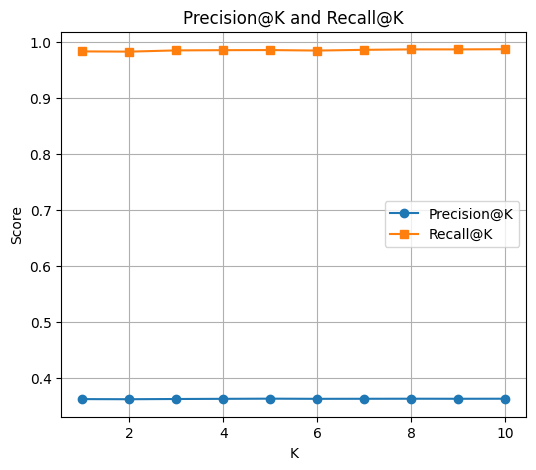

In [23]:
plt.figure(figsize=(6, 5))

# Plot precision and recall values
plt.plot(range(1, len(precision) + 1), precision, label='Precision@K', marker='o')
plt.plot(range(1, len(recall) + 1), recall, label='Recall@K', marker='s')

# Adding title and labels
plt.title("Precision@K and Recall@K")
plt.xlabel("K")
plt.ylabel("Score")

# Show legend
plt.legend()

# Show grid for better readability
plt.grid(True)

# Show plot
plt.show()